<font color="red"><h1>OpenSees Examples Manual using OpenSeesPy!</h1></font>
<h2><u>OpenSees Example 1a</u></h2>
<h2>Elastic Cantilever Column -- Dynamic analysis</h2>

You can find the original OpenSees examples manual using Tcl [here](https://opensees.berkeley.edu/wiki/index.php/Examples_Manual). (Original Examples in Tcl by Silvia Mazzoni & Frank McKenna, 2006.)

<h2><u>Simulation Process</u></h2>

In the following example, an input file (python script) is created to conduct a simulation in OpenSees. The process of creating the input file is broken-down into the following parts: 
### 1. Model definition
### 2. Output specification
### 3. Loads and Analysis
- Define gravity loads
- Analyse gravity loads
- Define lateral loads
- Analyse lateral loads




<h2><u>OpenSees Example 1a</u></h2>

### Elastic Cantilever Column -- EQ Ground Motion

This example has previously been converted to OpenSeesPy by SilviaMazzoni, 2020. The script can be found on her github page [here](https://github.com/silviamazzoni/OpenSeesPy_ExamplesManual/blob/main/BraineryBytes_OpenSees_Examples_Manual_Example_1a_Elastic_Cantilever_Column_EQgroundMotion.ipynb).

Introductory example 1a is a simple model of an elastic cantilever column. 

<img src="https://opensees.berkeley.edu/wiki/images/e/ea/Example1a_EQ.GIF">


In [346]:
# Import required modules
import openseespy.opensees as ops  # OpenSeesPy: The Python interface for OpenSees, used for finite element analysis.
import opsvis as opsv  # Visualization tool for OpenSees models.
import os  # Provides functions for interacting with the operating system.
import numpy as np # Python library used for scientific computing
import matplotlib.pyplot as plt  # Plotting library for data visualization.

In [347]:
# Check if a directory named 'Data' exists; if not, create one.
# This directory will store any data or results generated during the simulation.
if not os.path.exists('Data'): 
    os.mkdir('Data')

## Units


In [348]:
# Defining base units for the simulation.
m = 1.0  # Meter (base unit for length)
s = 1.0  # Second (base unit for time)
kg = 1.0  # Kilogram (base unit for mass)

# Derived units for force and pressure.
N = kg * m / s ** 2  # Newton (unit of force)
Pa = N / m ** 2  # Pascal (unit of pressure)

# Additional conversions for different units commonly used in structural engineering.
inches = 0.0254 * m  # Conversion factor for inches to meters.
ft = 12 * inches  # Conversion factor for feet to meters.
kip = 4448.2216152548 * N  # Conversion factor for kips (1000 pounds-force) to Newtons.
ksi = 6.895 * 10 ** 6 * Pa  # Conversion factor for ksi (1000 psi) to Pascals.

## Input Variables

In [349]:
column_length = 36 * ft # Column length

# Nodal coordinates
n1 = (0.0, 0.0) # Use floating point values
n2 = (0.0, column_length)

# Cross-sectional dimensions
b = 5 * ft # Breadth
d = 5 * ft # Depth
A = b * d # Area

# Elastic Modulus
E = 4227 * ksi

# Moment of Inertia
Iz = (b * d ** 3) / 12

# Loads/Actions
Py = -2000.0 * kip # Gravity load

Px = 1 # Lateral load

g = 9.81 # Gravitational acceleration (N / kg)

# Compute nodal mass
mass_x = abs(Py) / g # kg
print(f'The nodal mass value corresponding to the horizontal DOF is {mass_x:.0f} kg') # 
massValues = [mass_x, 1 * 10 ** -9, 0.0] # ndf nodal mass values corresponding to each DOF


The nodal mass value corresponding to the horizontal DOF is 906875 kg


Note: The negligible mass value in the vertical direction serves as a numerical trick to ensure stability and avoid singularities in certain computational methods, particularly in eigenvalue solvers.

## Model definition

**Wipe command**:  [OpenSeesPy](https://openseespydoc.readthedocs.io/en/latest/src/wipe.html), [OpenSees Tcl](https://opensees.berkeley.edu/wiki/index.php?title=Wipe_Command)

The wipe command is used to clear or reset the current model, removing all definitions, including nodes, elements, materials, constraints, and loads from memory.
You would typically use ops.wipe() at the beginning of a new analysis or simulation to ensure that any previous model definitions do not affect your current work

In [350]:
ops.wipe()  # Clear opensees model

**Model command**:  [OpenSeesPy](https://openseespydoc.readthedocs.io/en/latest/src/model.html), [OpenSees Tcl](https://opensees.berkeley.edu/wiki/index.php?title=Model_command)

The model command is used to create a ModelBuilder object, which establishes the fundamental framework for building a finite element model. A ModelBuilder object defines the type of model, the number of spatial dimensions, and the global default number of degrees of freedom per node. It determines the set of commands available for constructing the model. Once the ModelBuilder is defined, the user can create elements, nodes, load patterns, and other objects that make up the model. 

You can think of the ModelBuilder object as a template that sets up the basic structure of the model and defines the rules for how different components interact.

The 'basic' ModelBuilder is the primary and, as of now, only implemented ModelBuilder type. It provides all the necessary functionality to create a wide range of finite element models.



In [351]:
ops.model('basic', '-ndm', 2, '-ndf', 3)    # 2D model with 3 degrees of freedom per node.

**Node command**:  [OpenSeesPy](https://openseespydoc.readthedocs.io/en/latest/src/node.html), [OpenSees Tcl](https://opensees.berkeley.edu/wiki/index.php?title=Node_command)

The node command is used to define a node in the finite element model. It allows users to define nodes with specific properties, customise their degrees of freedom, and set initial conditions to suit various types of analyses, including static and dynamic simulations.

The nodeTag is a unique identifier (integer) for the node. Each node in the model must have a unique nodeTag to distinguish it from other nodes.

In [352]:
# Create nodes
nodal_crds = (n1, n2)
for nodeTag, crds in enumerate(nodal_crds, start = 1): # https://docs.python.org/3/library/functions.html#enumerate
    ops.node(nodeTag, *crds)

**Fix command**:  [OpenSeesPy](https://openseespydoc.readthedocs.io/en/latest/src/fix.html), [OpenSees Tcl](https://opensees.berkeley.edu/wiki/index.php?title=Fix_command)

The fix command is used to define the boundary conditions or constraints at a specific node in the model. This command specifies which degrees of freedom (DOFs) at a node are fixed and which are free to move.

In a 2D model, each node typically has 3 DOFs. The contraint values (constrValues) correspond to the DOFs: ux, uy, rz.  
In a 3D model, each node typically has 6 DOFs. The contraint values (constrValues) correspond to the DOFs: ux, uy, uz, rx, ry, rz.

Note: By default, all nodes in OpenSeesPy are considered free (unconstrained) unless explicitly constrained using commands like ops.fix.

In [353]:
# Boundary Conditions - single point constraints
constrValues = [1, 1, 1]
ops.fix(1, *constrValues)   # Node 1 is a fixed connection
# ops.fix(2, 0, 0, 0)         # Node 2 is free

**opsv.plot_model command**:  [opsvis](https://opsvis.readthedocs.io/en/latest/plot_model.html)

The opsv.plot_model() command is used to visualise the model that has been created using the OpenSeesPy library. The visualisation provides a graphical representation, allowing the user to check if the model's setup is correct and matches the intended design.

Text(0.5, 1.0, 'plot_model after defining nodes')

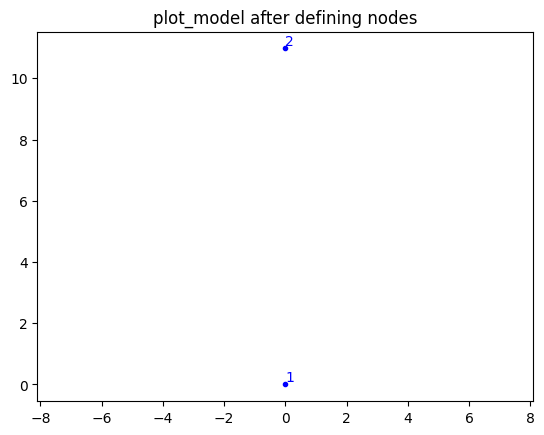

In [354]:
opsv.plot_model()
plt.title('plot_model after defining nodes')

**geomTransf command**:  [OpenSeesPy](https://openseespydoc.readthedocs.io/en/latest/src/geomTransf.html), [OpenSees Tcl](https://opensees.berkeley.edu/wiki/index.php?title=Geometric_Transformation_Command)

The geomTransf command is used to create a coordinate-transformation (CrdTransf) object that defines the geometric transformation between an element's local coordinate system and the global coordinate system of the model. This transformation is essential for accurately analysing the structural behaviour of the element within the overall model.

The transfType argument specifies the type of geometric transformation to be applied to the frame element.  The available transformation types include:
- Linear: A simple linear transformation that assumes small deformations and rotations. This transformation is suitable for most first-order, linear analyses where large deformations or rotations are not expected.  

- PDelta: Accounts for P-Δ effects, which are the additional moments induced by axial forces when there are small lateral displacements. This is useful in second-order, elastic analysis where geometric nonlinearity is considered.

- Corotational: Suitable for large deformation analysis. It captures both large rotations and translations, and it is used in second-order, nonlinear analysis.




In [355]:
# Define geometric transformation: performs a linear geometric transformation of beam stiffness and resisting force from the local-coordinate system to the global-coordinate system
ops.geomTransf('Linear', 1)     #  associate a tag of 1 to transformation

In [356]:
# # Define Materials
# ops.uniaxialMaterial("Elastic", 1, E)

**element command**:  [OpenSeesPy](https://openseespydoc.readthedocs.io/en/latest/src/element.html), [OpenSees Tcl](https://opensees.berkeley.edu/wiki/index.php?title=Element_Command)

The element command is used to define an element in an OpenSees model, specifying its type, identifier, connectivity, and additional properties.

Parameters:

- eleType: The type of the element (e.g., "Truss", "Beam", "Shell"), which determines its behaviour and formulation.

- eleTag: A unique identifier (integer) for the element, used to reference it within the model.

- *eleNodes: A list of node tags (integers) representing the nodes connected by the element. The required number depends on the eleType.

- *eleArgs: Additional arguments specific to the element type (e.g., material properties, section definitions). These vary based on the eleType.

In [357]:
# connectivity: (make A very large, 10e6 times its actual value)
# element elasticBeamColumn eleTag iNode jNode A E Iz transfTag
ops.element('elasticBeamColumn', 1, 1, 2, A * 10 ** 6, E, Iz, 1)     # element elasticBeamColumn 1 1 2 3600000000 4227 1080000 1;

Text(0.5, 1.0, 'plot_model after defining elements')

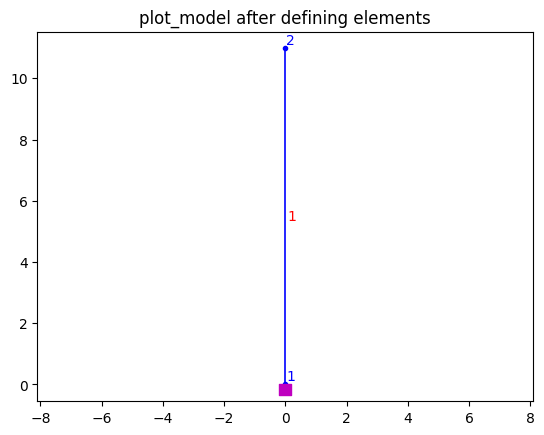

In [358]:
opsv.plot_model()
plt.title('plot_model after defining elements')

**mass command**:  [OpenSeesPy](https://openseespydoc.readthedocs.io/en/latest/src/mass.html), [OpenSees Tcl](https://opensees.berkeley.edu/wiki/index.php?title=Mass_Command)

The mass command assigns mass values to a specified node in a structural model.

Parameters:
- nodeTag: An integer identifier for the node to which the mass is applied.

- *massValues: A list of mass values, each corresponding to a degree of freedom (DOF) at the node. The number of values should match the number of DOFs defined for that node.

This command sets the translational and/or rotational mass at a node, which is essential for dynamic analyses, as it influences the inertia properties of the model during simulation.

In [359]:
# nodal masses: Time - 23:30, 32:20
ops.mass(2, *massValues)     #  node ,  Mass=Weight/g.

## Output specification

**recorder command**:  [OpenSeesPy](https://openseespydoc.readthedocs.io/en/latest/src/recorder.html), [OpenSees Tcl](https://opensees.berkeley.edu/wiki/index.php?title=Recorder_Command)

The recorder command is used to create a recorder that captures specific output data during a simulation, such as displacements, forces, or accelerations, and writes it to a file or other output formats.

Parameters:
- recorderType: Specifies the type of recorder, such as "Node", "Element", "Envelope", etc., which defines what kind of data is recorded (e.g., node displacements, element forces).

- *recorderArgs: A set of arguments that specify details for the recorder, such as the nodes or elements to record, the type of response (e.g., "disp" for displacement), file name, and output options.

The ops.recorder command is essential for monitoring the results of the analysis by tracking the response of specified nodes or elements over time or at particular analysis steps.

In [360]:
# Define Recorders

# https://openseespydoc.readthedocs.io/en/latest/src/nodeRecorder.html#node-recorder-command
# recorder('Node', '-file', filename, '-time', '-node', *nodeTags=[], '-dof', *dofs=[], respType)
dofs = [1, 2, 3]
ops.recorder('Node', '-file', 'Data/DispFreeEx1aEQ.out', '-time', '-node', 2, '-dof', *dofs, 'disp')     #  displacements of free node
ops.recorder('Node', '-file', 'Data/DispBaseEx1aEQ.out', '-time', '-node', 1, '-dof', *dofs, 'disp')     #  displacements of support node
ops.recorder('Node', '-file', 'Data/ReacBaseEx1aEQ.out', '-time', '-node', 1, '-dof', *dofs, 'reaction')     #  support reaction

# https://openseespydoc.readthedocs.io/en/latest/src/elementRecorder.html#element-recorder-command
# recorder('Element', '-file', filename, '-time', '-ele', *eleTags=[], '-eleRange', startEle, endEle, '-region', regionTag, *args)
ops.recorder('Element', '-file', 'Data/FColEx1aEQ.out', '-time', '-ele', 1, 'globalForce')     #  element forces -- column
ops.recorder('Element', '-file', 'Data/DColEx1aEQ.out', '-time', '-ele', 1, 'deformation')     #  element deformations -- column

79

## Loads and Analysis

### Load definition (Gravity Loads)

**timeSeries command**:  [OpenSeesPy](https://openseespydoc.readthedocs.io/en/latest/src/timeSeries.html), [OpenSees Tcl](https://opensees.berkeley.edu/wiki/index.php?title=Time_Series_Command)

In [361]:
# Define GRAVITY Loads-------------------------------------------------------------
ops.timeSeries('Linear', 1)  # timeSeries Linear 1;

**pattern command**:  [OpenSeesPy](https://openseespydoc.readthedocs.io/en/latest/src/pattern.html), [OpenSees Tcl](https://opensees.berkeley.edu/wiki/index.php?title=Pattern_Command)

In [362]:
# Define Load Pattern
ops.pattern('Plain', 1, 1)

**load command**:  [OpenSeesPy](https://openseespydoc.readthedocs.io/en/latest/src/load.html), [OpenSees Tcl](https://opensees.berkeley.edu/wiki/index.php?title=NodalLoad_Command)

In [363]:
ops.load(2, 0.0, Py, 0.0)   #  node , FX FY MZ -- superstructure-weight

### Analysis generation (Gravity loads)

**wipeAnalysis command**:  [OpenSeesPy](https://openseespydoc.readthedocs.io/en/latest/src/wipeAnalysis.html), [OpenSees Tcl](https://opensees.ist.berkeley.edu/wiki/index.php?title=WipeAnalysis_Command)  
**system command**:  [OpenSeesPy](https://openseespydoc.readthedocs.io/en/latest/src/system.html), [OpenSees Tcl](https://opensees.ist.berkeley.edu/wiki/index.php?title=System_Command)  
**numberer command**:  [OpenSeesPy](https://openseespydoc.readthedocs.io/en/latest/src/numberer.html), [OpenSees Tcl](https://opensees.ist.berkeley.edu/wiki/index.php?title=Numberer_Command)  
**constraints command**:  [OpenSeesPy](https://openseespydoc.readthedocs.io/en/latest/src/constraints.html), [OpenSees Tcl](https://opensees.ist.berkeley.edu/wiki/index.php?title=Constraints_Command)  
**integrator command**:  [OpenSeesPy](https://openseespydoc.readthedocs.io/en/latest/src/integrator.html), [OpenSees Tcl](https://opensees.ist.berkeley.edu/wiki/index.php?title=integrator_Command)  
**algorithm command**:  [OpenSeesPy](https://openseespydoc.readthedocs.io/en/latest/src/algorithm.html), [OpenSees Tcl](https://opensees.ist.berkeley.edu/wiki/index.php?title=algorithm_Command)  
**analysis command**:  [OpenSeesPy](https://openseespydoc.readthedocs.io/en/latest/src/analysis.html), [OpenSees Tcl](https://opensees.ist.berkeley.edu/wiki/index.php?title=analysis_Command)  
**test command**:  [OpenSeesPy](https://openseespydoc.readthedocs.io/en/latest/src/test.html), [OpenSees Tcl](https://opensees.ist.berkeley.edu/wiki/index.php?title=test_Command)  
**analyze command**:  [OpenSeesPy](https://openseespydoc.readthedocs.io/en/latest/src/analyze.html), [OpenSees Tcl](https://opensees.ist.berkeley.edu/wiki/index.php?title=analyze_Command)  
**loadConst command**:  [OpenSeesPy](https://openseespydoc.readthedocs.io/en/latest/src/loadConst.html), [OpenSees Tcl](https://opensees.ist.berkeley.edu/wiki/index.php?title=loadConst_Command)

In [364]:
ops.wipeAnalysis()     # adding this to clear Analysis module
ops.system('BandGeneral')     #  how to store and solve the system of equations in the analysis
ops.numberer('Plain')     #  renumber dofs to minimise band-width (optimisation), if you want to
ops.constraints('Plain')     #  how it handles boundary conditions
ops.integrator('LoadControl',0.1)     #  determine the next time step for an analysis,   apply gravity in 10 steps
ops.algorithm('Newton')     #  use Newtons solution algorithm: updates tangent stiffness at every iteration
ops.analysis('Static')     #  define type of analysis static or transient
ops.test('NormDispIncr',1.0e-8,6)     #  determine if convergence has been achieved at the end of an iteration step
ops.analyze(10)     #  perform gravity analysis
ops.loadConst('-time',0.0)     #  hold gravity constant and restart time


100


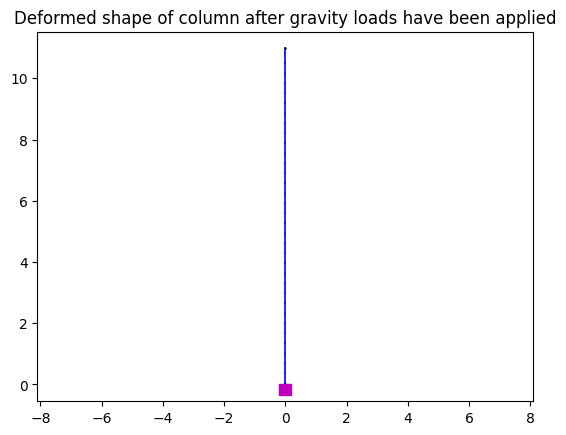

In [365]:
sfac = opsv.plot_defo(sfac = 100)
plt.title('Deformed shape of column after gravity loads have been applied')
print(sfac)

### Load definition (Lateral loads)

**timeSeries command**:  [OpenSeesPy](https://openseespydoc.readthedocs.io/en/latest/src/timeSeries.html), [OpenSees Tcl](https://opensees.ist.berkeley.edu/wiki/index.php?title=time_Series_Command)  
**pattern command**:  [OpenSeesPy](https://openseespydoc.readthedocs.io/en/latest/src/pattern.html), [OpenSees Tcl](https://opensees.ist.berkeley.edu/wiki/index.php?title=pattern_Command)  
**rayleigh command**:  [OpenSeesPy](https://openseespydoc.readthedocs.io/en/latest/src/reyleigh.html), [OpenSees Tcl](https://opensees.berkeley.edu/wiki/index.php?title=Rayleigh_Damping_Command)

In [366]:
# DYNAMIC ground-motion analysis -------------------------------------------------------------
# create load pattern
# define acceleration vector from file (dt=0.01 is associated with the input file gm)
accelSeries  = 900
ops.timeSeries('Path',accelSeries,'-dt',0.01,'-filePath','EQ_files/BM68elc.acc','-factor',1)     # timeSeries Path accelSeries -dt 0.01 -filePath BM68elc.acc -factor 1;
ops.pattern('UniformExcitation',2,1,'-accel',accelSeries)     #  define where and how (pattern tag, dof) acceleration is applied
ops.rayleigh(0.,0.,0.,2*0.02/np.pow(ops.eigen('-fullGenLapack',1)[0],0.5))     #  set damping based on first eigen mode



### Analysis generation (Lateral loads)

**wipeAnalysis command**:  [OpenSeesPy](https://openseespydoc.readthedocs.io/en/latest/src/wipeAnalysis.html), [OpenSees Tcl](https://opensees.ist.berkeley.edu/wiki/index.php?title=wipeAnalysis_Command)  
**constraints command**:  [OpenSeesPy](https://openseespydoc.readthedocs.io/en/latest/src/constraints.html), [OpenSees Tcl](https://opensees.ist.berkeley.edu/wiki/index.php?title=constraints_Command)  
**numberer command**:  [OpenSeesPy](https://openseespydoc.readthedocs.io/en/latest/src/numberer.html), [OpenSees Tcl](https://opensees.ist.berkeley.edu/wiki/index.php?title=numberer_Command)  
**system command**:  [OpenSeesPy](https://openseespydoc.readthedocs.io/en/latest/src/system.html), [OpenSees Tcl](https://opensees.ist.berkeley.edu/wiki/index.php?title=system_Command)  
**test command**:  [OpenSeesPy](https://openseespydoc.readthedocs.io/en/latest/src/test.html), [OpenSees Tcl](https://opensees.ist.berkeley.edu/wiki/index.php?title=test_Command)  
**algorithm command**:  [OpenSeesPy](https://openseespydoc.readthedocs.io/en/latest/src/algorithm.html), [OpenSees Tcl](https://opensees.ist.berkeley.edu/wiki/index.php?title=algorithm_Command)  
**integrator command**:  [OpenSeesPy](https://openseespydoc.readthedocs.io/en/latest/src/integrator.html), [OpenSees Tcl](https://opensees.ist.berkeley.edu/wiki/index.php?title=integrator_Command)  
**analysis command**:  [OpenSeesPy](https://openseespydoc.readthedocs.io/en/latest/src/analysis.html), [OpenSees Tcl](https://opensees.ist.berkeley.edu/wiki/index.php?title=analysis_Command)  
**analyze command**:  [OpenSeesPy](https://openseespydoc.readthedocs.io/en/latest/src/analyze.html), [OpenSees Tcl](https://opensees.ist.berkeley.edu/wiki/index.php?title=analyze_Command)

In [367]:
# create the analysis
ops.wipeAnalysis()     #  clear previously-define analysis parameters
ops.constraints('Plain')     #  how it handles boundary conditions
ops.numberer('Plain')     #  renumber dofs to minimize band-width (optimization), if you want to
ops.system('BandGeneral')     #  how to store and solve the system of equations in the analysis
ops.test('NormDispIncr',1.0e-8,10)     #  determine if convergence has been achieved at the end of an iteration step
ops.algorithm('Newton')     #  use Newtons solution algorithm: updates tangent stiffness at every iteration
ops.integrator('Newmark',0.5,0.25)     #  determine the next time step for an analysis
ops.analysis('Transient')     #  define type of analysis: time-dependent
ops.analyze(1000,0.02)     #  apply 1000 0.02-sec time steps in analysis

print('Done!')

Done!


## Output

Display the free-node displacement

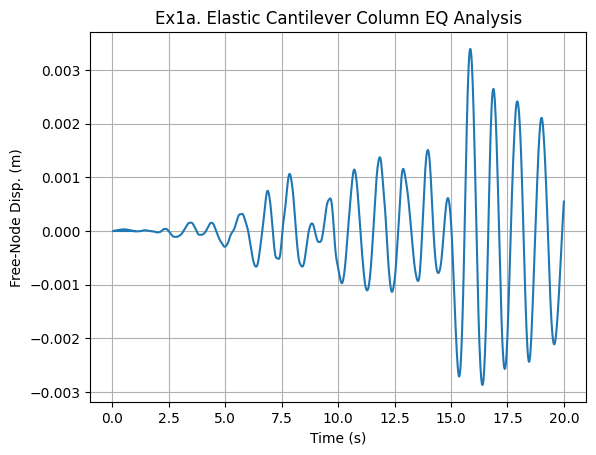

End of Run


In [368]:
ops.wipe()
plt.close('all')

# Load the data
fname3 = 'Data/DispFreeEx1aEQ.out'
dataDFree = np.loadtxt(fname3) # https://numpy.org/doc/stable/reference/generated/numpy.loadtxt.html#numpy.loadtxt

# Create a figure and axes instances
fig, ax = plt.subplots(1, 1)

# Plot on the first axis
ax.set_title('Ex1a. Elastic Cantilever Column EQ Analysis')
ax.grid(True)
ax.plot(dataDFree[:, 0], dataDFree[:, 1])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Free-Node Disp. (m)')

plt.show()

# End of script
print('End of Run')